# EE 418 Project

Members: Simon Chen (1832768), 
Kejin Li (1978130), 
Andres Guerrero-Guzman (1066684), 
Khoa Tran (1861460)


Contribution of Each Member:

Simon Chen:

Kejin Li:

Andres Guerrero-Guzman: 

- TODO: Compute curr_avg_offset_us and curr_acc_offset_us for NTP-based IDS
- TODO: Implement the RLS algorithm
- TODO: 1) Normalize curr_error_sample, 2) compute curr_L_upper and curr_L_lower


Khoa Tran:

In [36]:
"""
This implements both state-of-the-art and NTP-based IDSs.
"""

import numpy as np

__author__ = "ee418"


class IDS:
    def __init__(self, T_sec, N, mode):
        if (mode != 'state-of-the-art') & (mode != 'ntp-based'):
            raise ValueError('Unknown IDS mode')

        self.mode = mode

        self.k = 0  # Current batch
        self.N = N  # Batch size
        self.T_sec = T_sec # Nominal period in sec

        self.mu_T_sec = 0            # Average inter-arrival time in the current batch (sec)
        self.batch_end_time_sec = 0  # End time of every batch (sec)
        self.init_time_sec = 0       # Arrival time of the 1st message in the 2nd batch (sec)
        self.elapsed_time_sec = 0    # Elapsed time since the 1st message in the 2nd batch (sec)

        self.acc_offset_us = 0  # Most recent accumulated offset (us)
        self.avg_offset_us = 0  # Most recent average offset (us)
        self.skew = 0           # Most recent estimated skew (ppm)
        self.P = 1              # Parameter used in RLS

        self.mu_T_sec_hist = []
        self.batch_end_time_sec_hist = []
        self.elapsed_time_sec_hist = []
        self.acc_offset_us_hist = []
        self.avg_offset_us_hist = []
        self.skew_hist = []
        self.error_hist = []

        # CUSUM
        self.is_detected = 0

        self.n_init = 50  # Number of error samples for initializing mu_e and sigma_e
        self.k_CUSUM_start = self.n_init + 1  # CUSUM starts after mu and sigma are initialized

        self.Gamma = 5  # Control limit threshold
        self.gamma = 4  # Update threshold
        self.kappa = 8  # Sensitivity parameter in CUSUM

        self.L_upper = 0  # Most recent upper control limit
        self.L_lower = 0  # Most recent upper control limit
        self.e_ref = []   # Reference (un-normalized) error samples; used to compute mu_e and sigma_e

        self.L_upper_hist = []
        self.L_lower_hist = []

    # `a` is a 1-by-N vector that contains arrival timestamps of the latest batch.
    def update(self, a):
        if len(a) != self.N:
            raise ValueError('Inconsistent batch size')

        self.k += 1
        self.batch_end_time_sec_hist.append(a[-1])

        if self.k == 1:     # Initialize something in the first batch
            if self.mode == 'state-of-the-art':
                self.mu_T_sec = np.mean(a[1:] - a[:-1])
            return

        # CIDS officially starts from the second batch
        if self.k == 2:
            self.init_time_sec = a[0]

        if self.k >= 2:
            curr_avg_offset_us, curr_acc_offset_us = self.estimate_offset(a)
            curr_error_sample = self.update_clock_skew(curr_avg_offset_us, curr_acc_offset_us)
            self.update_cusum(curr_error_sample)

    def estimate_offset(self, a):
        self.elapsed_time_sec = a[-1] - self.init_time_sec
        self.elapsed_time_sec_hist.append(self.elapsed_time_sec)

        prev_mu_T_sec = self.mu_T_sec           # You will use it later.
        self.mu_T_sec = np.mean(a[1:] - a[:-1])
        self.mu_T_sec_hist.append(self.mu_T_sec)

        prev_acc_offset_us = self.acc_offset_us # You will use it later.
        a0 = self.batch_end_time_sec_hist[-2]   # Arrival timestamp of the last message in the previous batch
                                                # You will use it later. 

        curr_avg_offset_us, curr_acc_offset_us = 0, 0

        if self.mode == 'state-of-the-art':
            # ====================== Start of Your Code =========================
            # TODO: Compute curr_avg_offset_us and curr_acc_offset_us for state-of-the-art IDS

            # Your code goes here. 
            SUM = 0
            for i in range(0, self.N - 1):
                SUM += (a[i+1] - (a[0] + ((i+1) * prev_mu_T_sec)))
                
            curr_avg_offset_us = SUM / self.N
            curr_acc_offset_us = prev_acc_offset_us + abs(curr_avg_offset_us)
            
            # ====================== End of Your Code =========================

        elif self.mode == 'ntp-based':
            # ====================== Start of Your Code =========================
            # TODO: Compute curr_avg_offset_us and curr_acc_offset_us for NTP-based IDS

            # Your code goes here. 
            #Andres Contribution:
            
            cur_avg_offset_us = (self.T_sec  - ((a[self.N - 1] - a0)/self.N))
            curr_acc_offset_us = prev_acc_offset_us + (self.N * cur_avg_offset_us) 

            # ====================== End of Your Code =========================

        return curr_avg_offset_us, curr_acc_offset_us

    def update_clock_skew(self, curr_avg_offset_us, curr_acc_offset_us):
        prev_skew = self.skew
        prev_P = self.P

        # Compute identification error
        time_elapsed_sec = self.elapsed_time_sec
        curr_error = curr_acc_offset_us - prev_skew * time_elapsed_sec

        # ====================== Start of Your Code =========================
        # RLS algorithm
        # Inputs:
        #   t[k] -> time_elapsed_sec
        #   P[k-1] -> prev_P
        #   S[k-1] -> prev_skew
        #   e[k] -> curr_error
        #   lambda -> l
        #
        # Outputs:
        #   P[k] -> curr_P
        #   S[k] -> curr_skew
        #
        # TODO: Implement the RLS algorithm

        # Your code goes here. 
        #Andres Contribution
        def Recursive_Least_Squares(time_elapsed_sec, prev_P, prev_skew, curr_error, l):
            e = curr_error
            #G = gain at current k
            G = ((1.0/l)*prev_P*time_elapsed_sec)/(1.0 + (1.0/l)*((time_elapsed_sec)**2.0)*prev_P)
            
            #calculating Curr_P and curr_skew
            curr_P = (1.0/l)*(prev_P - G*time_elapsed_sec*prev_P)
            curr_skew = prev_skew + G*curr_error
            
            return curr_P, curr_skew
        
        curr_skew = Recursive_Least_Squares(time_elapsed_sec, prev_P, prev_skew, curr_error,0.9995)[1]
        curr_P = Recursive_Least_Squares(time_elapsed_sec, prev_P, prev_skew, curr_error,0.9995)[0]
        # ====================== End of Your Code =========================

        # Update the state of IDS
        self.avg_offset_us = curr_avg_offset_us
        self.acc_offset_us = curr_acc_offset_us
        self.skew = curr_skew
        self.P = curr_P

        self.avg_offset_us_hist.append(curr_avg_offset_us)
        self.acc_offset_us_hist.append(curr_acc_offset_us)
        self.skew_hist.append(curr_skew)
        self.error_hist.append(curr_error)

        return curr_error

    def update_cusum(self, curr_error_sample):
        if self.k <= self.k_CUSUM_start:
            self.e_ref.append(curr_error_sample)
            return

        prev_L_upper = self.L_upper
        prev_L_lower = self.L_lower

        # Compute mu_e and sigma_e
        e_ref_arr = np.asarray(self.e_ref)
        mu_e = np.mean(e_ref_arr)
        sigma_e = np.std(e_ref_arr)

        kappa = self.kappa

        # ====================== Start of Your Code =========================
        # TODO: 1) Normalize curr_error_sample, 2) compute curr_L_upper and curr_L_lower
        # Store the normalized error in `normalized_error`

        # Your code goes here. 
        #Andres contribution:
        
        #compute normalized error
        normalized_error = (curr_error_sample - mu_e)/sigma_e
        
        #compute L^+ and L^-
        curr_L_upper = max(0, prev_L_upper + normalized_error - kappa)
        curr_L_lower = max(0, prev_L_lower - normalized_error - kappa)
        
        # ====================== End of Your Code =========================

        if (curr_L_upper > self.Gamma) | (curr_L_lower > self.Gamma):
            self.is_detected = True

        # Store valid (un-normalized) error sample
        if abs(normalized_error) < self.gamma:
            self.e_ref.append(curr_error_sample)

        # Update the state of CUSUM
        self.L_upper = curr_L_upper
        self.L_lower = curr_L_lower

        self.L_upper_hist.append(curr_L_upper)
        self.L_lower_hist.append(curr_L_lower)

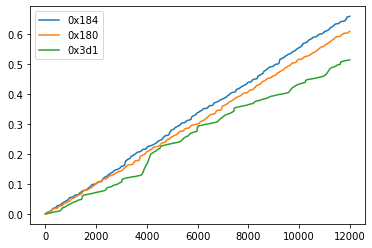

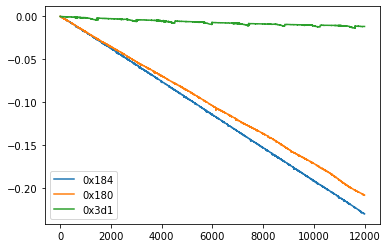

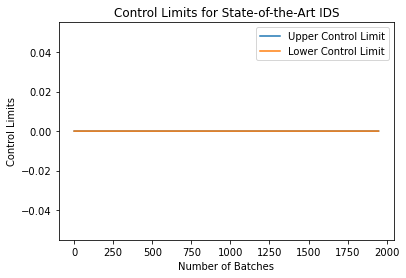

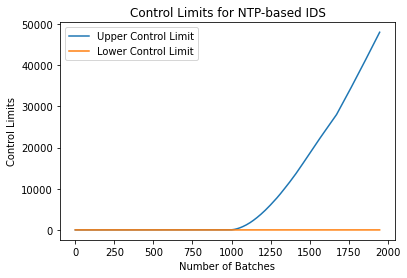

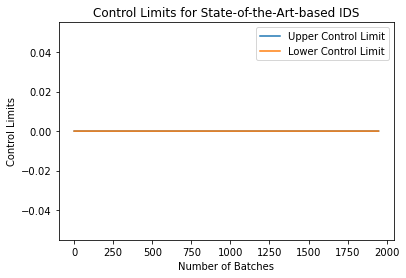

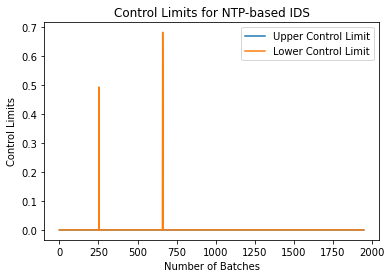

In [37]:
__author__ = "ee418"

import numpy as np
import matplotlib.pyplot as plt

def import_data(file=None):
    with open(file) as f:
        lines = f.readlines()
    data = [float(x.strip()) for x in lines]
    return data


# TODO: Plot accumulated offset curves for both state-of-the-art and NTP-based IDSs.
def plot_acc_offsets(ids, mode):
    if mode == 'state-of-the-art':
        # ====================== Start of Your Code =========================
        # Example: Plot accumulated offset curve for 0x184.
        # Your code goes here.
        plt.plot(ids['184-sota'].elapsed_time_sec_hist, ids['184-sota'].acc_offset_us_hist, label='0x184')
        plt.plot(ids['180-sota'].elapsed_time_sec_hist, ids['180-sota'].acc_offset_us_hist, label='0x180')
        plt.plot(ids['3d1-sota'].elapsed_time_sec_hist, ids['3d1-sota'].acc_offset_us_hist, label='0x3d1')
        plt.legend()
        plt.show()

        # ====================== End of Your Code =========================
    elif mode == 'ntp-based':
        # ====================== Start of Your Code =========================

        # Your code goes here
        plt.plot(ids['184-ntp'].elapsed_time_sec_hist, ids['184-ntp'].acc_offset_us_hist, label='0x184')
        plt.plot(ids['180-ntp'].elapsed_time_sec_hist, ids['180-ntp'].acc_offset_us_hist, label='0x180')
        plt.plot(ids['3d1-ntp'].elapsed_time_sec_hist, ids['3d1-ntp'].acc_offset_us_hist, label='0x3d1')
        plt.legend()
        plt.show()
        # ====================== End of Your Code =========================


# TODO: Implement this simulation (N=20)
def simulation_masquerade_attack(mode):

    if mode == 'state-of-the-art':
        
        data_184 = import_data('184.txt')
        data_3d1 = import_data('3d1.txt')

        N = 20

        # Construct a new data-set with the first 1000 batches of data_184,
        # followed by 1000 batches of data_3d1. That is, the masquerade
        # attack occurs at the 1001-st batch.
        data_184 = np.asarray(data_184[0:1000 * N]) - data_184[0]  # Relative timestamps
        data_3d1 = np.asarray(data_3d1[0:1000 * N]) - data_3d1[0]  # Relative timestamps
        data = np.append(data_184, data_184[-1] + 0.1 + data_3d1)  # The 1st spoofed message occurs exactly 0.1 sec
                                                                   # (the period) after the last legitimate message.

        ids = IDS(T_sec=0.1, N=N, mode='state-of-the-art')

        batch_num = 2000
        for i in range(batch_num):
            batch = np.asarray(data[i * N:(i + 1) * N])
            ids.update(batch)

        plt.plot(ids.L_upper_hist, label='Upper Control Limit')
        plt.plot(ids.L_lower_hist, label='Lower Control Limit')
        plt.xlabel('Number of Batches')
        plt.ylabel('Control Limits')
        plt.title('Control Limits for State-of-the-Art IDS')
        plt.legend()
        plt.show()
    elif mode == 'ntp-based':
        # ====================== Start of Your Code =========================
        
        # Your code goes here.
        data_184 = import_data('184.txt')
        data_3d1 = import_data('3d1.txt')

        N = 20

        # Construct a new data-set with the first 1000 batches of data_184,
        # followed by 1000 batches of data_3d1. That is, the masquerade
        # attack occurs at the 1001-st batch.
        data_184 = np.asarray(data_184[0:1000 * N]) - data_184[0]  # Relative timestamps
        data_3d1 = np.asarray(data_3d1[0:1000 * N]) - data_3d1[0]  # Relative timestamps
        data = np.append(data_184, data_184[-1] + 0.1 + data_3d1)  # The 1st spoofed message occurs exactly 0.1 sec
                                                                   # (the period) after the last legitimate message.

        ids = IDS(T_sec=0.1, N=N, mode='ntp-based')

        batch_num = 2000
        for i in range(batch_num):
            batch = np.asarray(data[i * N:(i + 1) * N])
            ids.update(batch)

        plt.plot(ids.L_upper_hist, label='Upper Control Limit')
        plt.plot(ids.L_lower_hist, label='Lower Control Limit')
        plt.xlabel('Number of Batches')
        plt.ylabel('Control Limits')
        plt.title('Control Limits for NTP-based IDS')
        plt.legend()
        plt.show()
        # ====================== End of Your Code  =========================


# TODO: Implement this simulation (N=20)
def simulation_cloaking_attack(mode):
    if mode == 'state-of-the-art':
        # ====================== Start of Your Code =========================
        
        # Your code goes here.
        data_184 = import_data('184.txt')
        data_180 = import_data('180.txt')

        N = 20

        # Construct a new data-set with the first 1000 batches of data_184,
        # followed by 1000 batches of data_3d1. That is, the masquerade
        # attack occurs at the 1001-st batch.
        data_184 = np.asarray(data_184[0:1000 * N]) - data_184[0]  # Relative timestamps
        data_180 = np.asarray(data_180[0:1000 * N]) - data_180[0]  # Relative timestamps
        data = np.append(data_184, data_184[-1] + 0.1 + data_180)  # The 1st spoofed message occurs exactly 0.1 sec
                                                                   # (the period) after the last legitimate message.

        ids = IDS(T_sec=0.1, N=N, mode='state-of-the-art')

        batch_num = 2000
        for i in range(batch_num):
            batch = np.asarray(data[i * N:(i + 1) * N])
            ids.update(batch)
        plt.plot(ids.L_upper_hist, label='Upper Control Limit')
        plt.plot(ids.L_lower_hist, label='Lower Control Limit')
        plt.xlabel('Number of Batches')
        plt.ylabel('Control Limits')
        plt.title('Control Limits for State-of-the-Art-based IDS')
        plt.legend()
        plt.show()
        # ====================== End of Your Code =========================

    elif mode == 'ntp-based':
        # ====================== Start of Your Code =========================
        
        # Your code goes here.
        data_184 = import_data('184.txt')
        data_180 = import_data('180.txt')

        N = 20

        # Construct a new data-set with the first 1000 batches of data_184,
        # followed by 1000 batches of data_3d1. That is, the masquerade
        # attack occurs at the 1001-st batch.
        data_184 = np.asarray(data_184[0:1000 * N]) - data_184[0]  # Relative timestamps
        data_180 = np.asarray(data_180[0:1000 * N]) - data_180[0]  # Relative timestamps
        data = np.append(data_184, data_184[-1] + 0.1 + data_180)  # The 1st spoofed message occurs exactly 0.1 sec
                                                                   # (the period) after the last legitimate message.
        #if unexpected behavior remove \deltaT term (cloacking clock paper pg.8 col.1)
        ids = IDS(T_sec=0.1, N=N, mode='ntp-based')

        batch_num = 2000
        for i in range(batch_num):
            batch = np.asarray(data[i * N:(i + 1) * N])
            ids.update(batch)

        plt.plot(ids.L_upper_hist, label='Upper Control Limit')
        plt.plot(ids.L_lower_hist, label='Lower Control Limit')
        plt.xlabel('Number of Batches')
        plt.ylabel('Control Limits')
        plt.title('Control Limits for NTP-based IDS')
        plt.legend()
        plt.show()
        # ====================== End of Your Code =========================


if __name__ == '__main__':
    # If IDS is correctly implemented, you should be able to run the following code.
    data_184 = import_data('184.txt')
    data_3d1 = import_data('3d1.txt')
    data_180 = import_data('180.txt')

    data_184 = np.asarray(data_184) - data_184[0]
    data_3d1 = np.asarray(data_3d1) - data_3d1[0]
    data_180 = np.asarray(data_180) - data_180[0]

    ids = dict()

    N = 20      # Change this to 30 for Task 4
    ids['184-sota'] = IDS(T_sec=0.1, N=N, mode='state-of-the-art')
    ids['184-ntp'] = IDS(T_sec=0.1, N=N, mode='ntp-based')

    ids['3d1-sota'] = IDS(T_sec=0.1, N=N, mode='state-of-the-art')
    ids['3d1-ntp'] = IDS(T_sec=0.1, N=N, mode='ntp-based')

    ids['180-sota'] = IDS(T_sec=0.1, N=N, mode='state-of-the-art')
    ids['180-ntp'] = IDS(T_sec=0.1, N=N, mode='ntp-based')

    if N == 20:
        batch_num = 6000
    elif N == 30:
        batch_num = 4000
    else:
        batch_num = 6000

    for i in range(batch_num):
        batch_184 = data_184[i*N:(i+1)*N]
        ids['184-sota'].update(batch_184)
        ids['184-ntp'].update(batch_184)

        batch_3d1 = data_3d1[i*N:(i+1)*N]
        ids['3d1-sota'].update(batch_3d1)
        ids['3d1-ntp'].update(batch_3d1)

        batch_180 = data_180[i * N:(i + 1) * N]
        ids['180-sota'].update(batch_180)
        ids['180-ntp'].update(batch_180)


    # Task 2: Plot accumulated offset curves for 0x184, 0x3d1, and 0x180, for the state-of-the-art IDS.
    plot_acc_offsets(ids, "state-of-the-art")

    # Task 3: Plot accumulated offset curves for 0x184, 0x3d1, and 0x180, for the NTP-based IDS.
    plot_acc_offsets(ids, "ntp-based")

    # Task 4: Change N to 30, and repeat Tasks 2 and 3.
    # plot_acc_offsets(ids, "state-of-the-art")
    # plot_acc_offsets(ids, "ntp-based")

    # Task 5: Simulate the masquerade attack, and plot upper/lower control limits.
    simulation_masquerade_attack("state-of-the-art")
    simulation_masquerade_attack("ntp-based")

    # Task 6: Simulate the cloaking attack, and plot upper/lower control limits.
    simulation_cloaking_attack("state-of-the-art")
    simulation_cloaking_attack("ntp-based")

In [ ]:
#NTP based cloaking attack cannot be detected because \gamma = 5